In [1]:
# General imports
import os
import sys
import cortex
import numpy as np
import matplotlib.pyplot as plt

# Personals Import 
sys.path.append("{}/../utils".format(os.getcwd()))
from cifti_utils import from_170k_to_59k
from surface_utils import load_surface
from pycortex_utils import get_rois

In [2]:
main_dir = '/Users/uriel/disks/meso_shared'
code_dir = '/Users/uriel/disks/meso_H/projects'
project_dir = 'RetinoMaps'
subject = 'sub-01'

_170k_dir_ ='{}/{}/derivatives/fmriprep/fmriprep/{}/ses-01/func/'.format(main_dir,project_dir,subject)
_170k_fn = '{}_ses-01_task-pMF_run-01_space-fsLR_den-170k_bold.dtseries.nii'.format(subject)

mmp_rois_dir = '{}/{}/derivatives/pp_data/cortex/db/sub-170k/'.format(main_dir,project_dir,subject)
mmp_rois_fn = 'mmp_atlas_rois_59k.npz'


In [3]:
# load any 170k data to acces 59k mask 
img_170k, data_170k = load_surface('{}/{}'.format(_170k_dir_,_170k_fn))
rois_dict_59k = dict(np.load('{}/{}'.format(mmp_rois_dir,mmp_rois_fn)))

In [4]:
surfs = [cortex.polyutils.Surface(*d) for d in cortex.db.get_surf('sub-170k', "flat")]
surf_lh, surf_rh = surfs[0], surfs[1]
lh_vert_num, rh_vert_num = surf_lh.pts.shape[0], surf_rh.pts.shape[0]

In [5]:
results = from_170k_to_59k(img=img_170k, data=data_170k, return_concat_hemis=False, return_59k_mask=True)
data_59k_L = results['data_L']
data_59k_R = results['data_R']
mask_59k = results['mask_59k']

In [6]:
mask_59k_L = mask_59k[:lh_vert_num]
mask_59k_R = mask_59k[-rh_vert_num:]

In [7]:
rois_dict_59k_L = {roi: data[:lh_vert_num] for roi, data in rois_dict_59k.items()}
rois_dict_59k_R = {roi: data[-rh_vert_num:] for roi, data in rois_dict_59k.items()}

In [8]:
n_vertrx_170k = data_170k.shape[1]

rois_dict_170k_L = {}
for key, value in rois_dict_59k_L.items():
    rois_dict_170k_L[key] = value[mask_59k_L]
    vertex_to_add = n_vertrx_170k - len(value[mask_59k_L])
    rois_dict_170k_L[key] = np.concatenate((value[mask_59k_L], np.full(vertex_to_add, False)))

rois_dict_170k_R = {}
for key, value in rois_dict_59k_R.items():
    rois_dict_170k_R[key] = value[mask_59k_R]
    vertex_to_add = n_vertrx_170k - (len(value[mask_59k_R])+len(value[mask_59k_L]))
    
    
    
    
    rois_dict_170k_R[key] = np.concatenate((np.full(len(value[mask_59k_L]), False),value[mask_59k_R], np.full(vertex_to_add, False)))


In [9]:
atlas_dir = '{}/{}/analysis_code/atlas'.format(code_dir,project_dir)
os.makedirs(atlas_dir, exist_ok=True)
# save 170k and 59k atlas
rois_170k_fn_L = 'mmp_atlas_rois_170k_hemi-L.npz'
np.savez('{}/{}'.format(atlas_dir,rois_170k_fn_L), **rois_dict_170k_L)

rois_170k_fn_R = 'mmp_atlas_rois_170k_hemi-R.npz'
np.savez('{}/{}'.format(atlas_dir,rois_170k_fn_R), **rois_dict_170k_R)

rois_59k_fn = 'mmp_atlas_rois_59k.npz'
np.savez('{}/{}'.format(atlas_dir,rois_59k_fn), **rois_dict_59k)

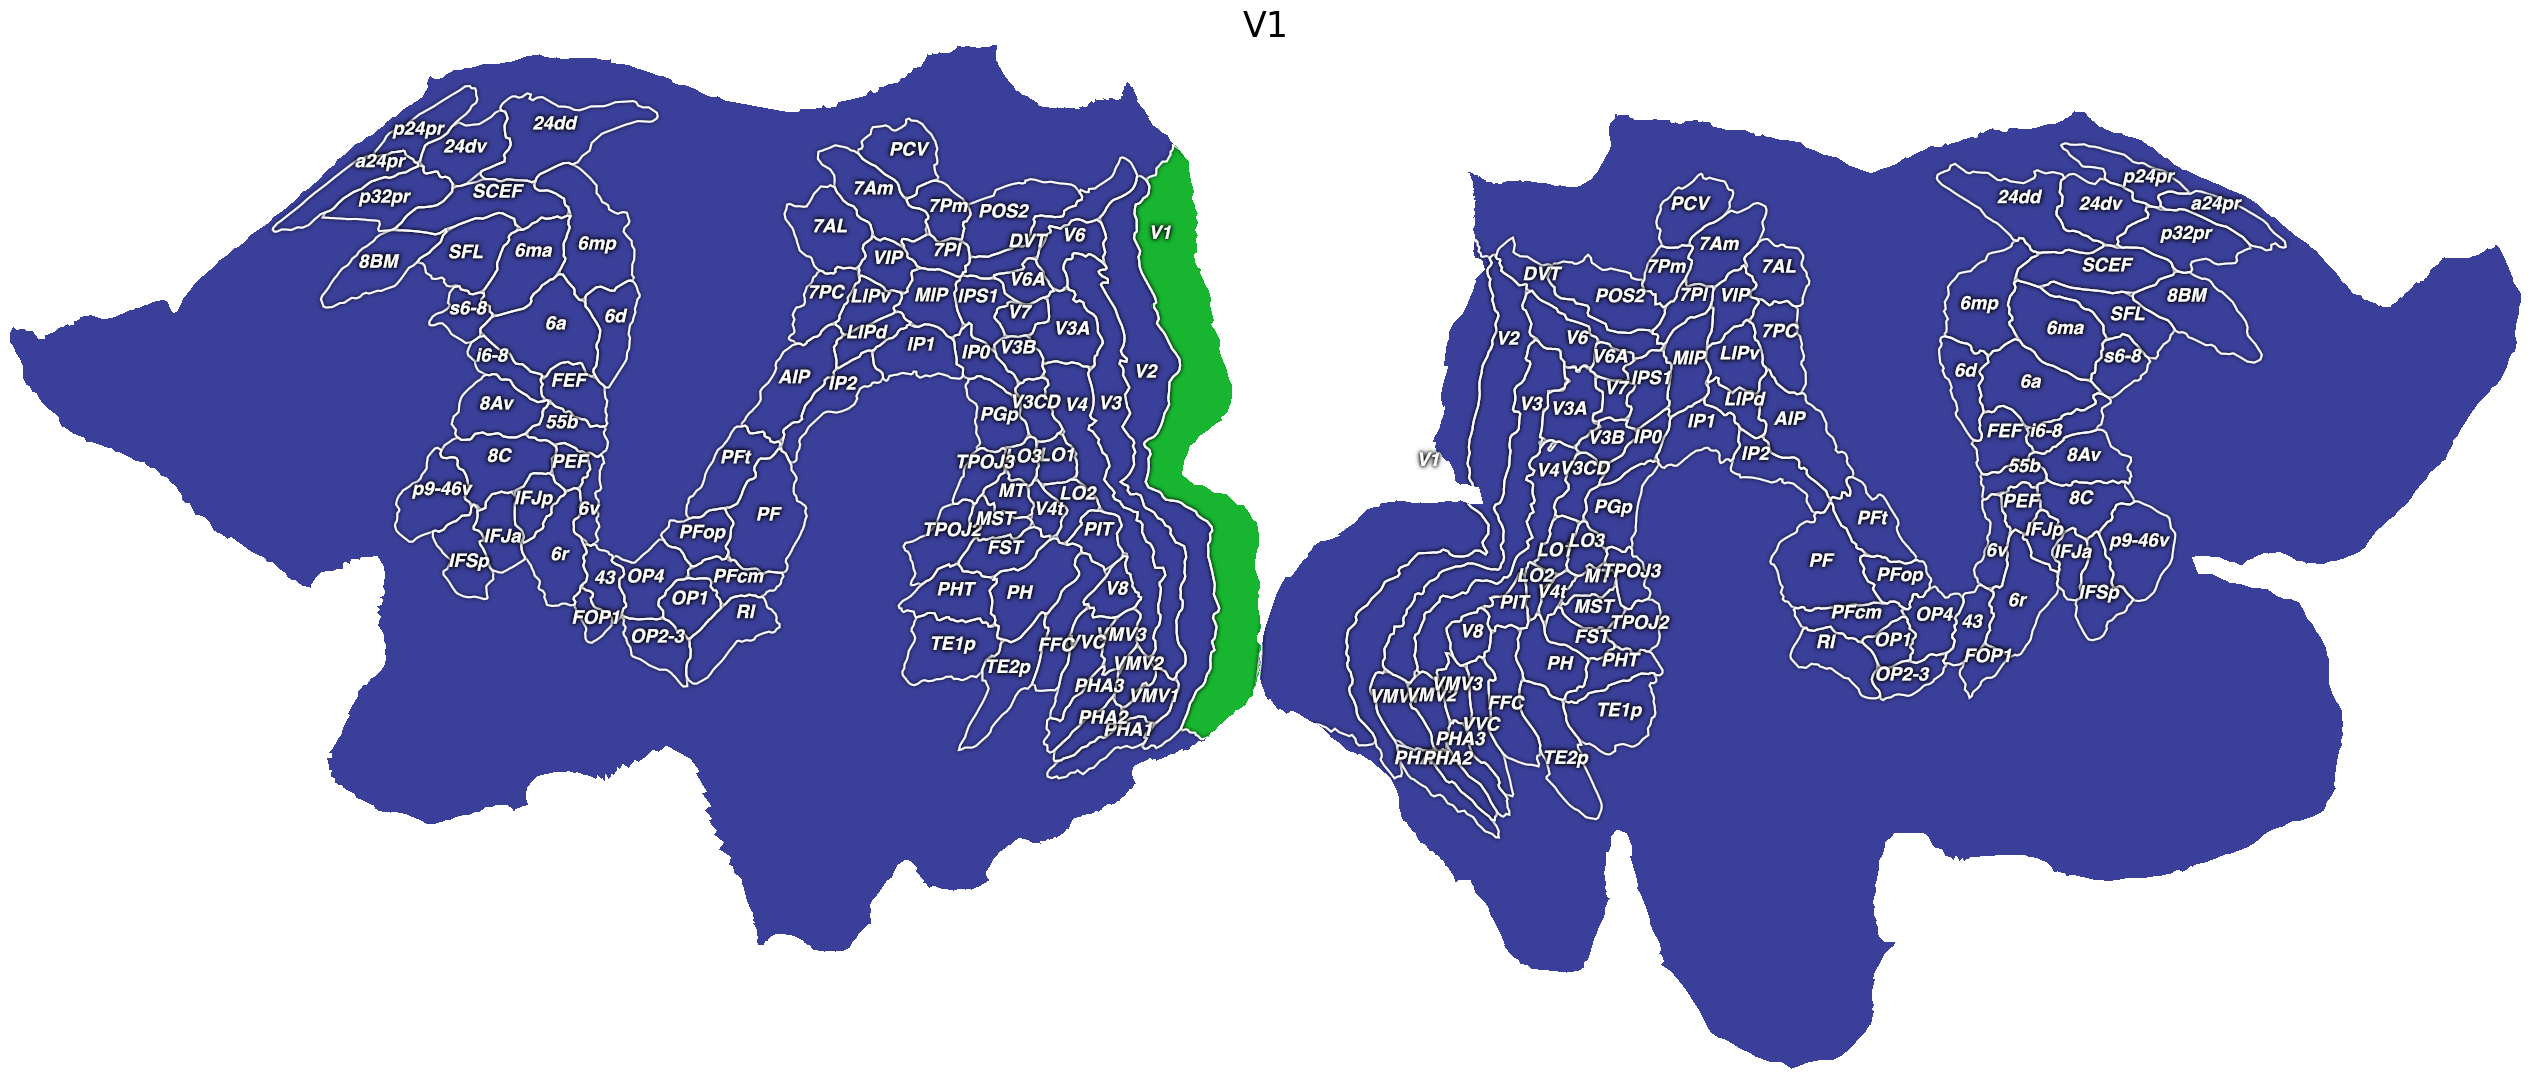

In [10]:
# Make verification with replot areas 
roi_name = 'V1'
pycortex_subject = 'sub-170k'
roi_data = np.array((rois_dict_170k_L[roi_name] == True).astype(np.int32)).reshape((1, rois_dict_170k_L[roi_name].shape[0]))

results = from_170k_to_59k(img=img_170k, data=roi_data, return_concat_hemis=True, return_59k_mask=False)
roi_data_59k = results['data_concat']

vertex_data = cortex.Vertex(roi_data_59k[0,:], pycortex_subject, cmap='BROYG', vmin=0, vmax=1)
cortex.quickshow(vertex_data, with_colorbar=False)
plt.title('{}'.format(roi_name),fontsize=25)
plt.show()